In [1]:
import pandas as pd
from drn_interactions.config import Config
from drn_interactions.interactions.popcup import PopulationCoupling
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.loaders import BaseShockSlowInteractionsLoader
from drn_interactions.interactions.pairwise import PairwiseCorr
from drn_interactions.interactions.runners import InteractionsRunner
from drn_interactions.io import load_derived_generic
from drn_interactions.config import Config, ExperimentInfo
from tqdm import tqdm
import warnings

dd = Config.derived_data_dir / "corrs"
dd.mkdir(exist_ok=True)

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [5]:
neuron_types = load_derived_generic("neuron_types.csv")
sessions = ExperimentInfo.foot_shock_sessions_10min
res_corr = []
res_pcup = []
bin_widths = [0.05, 0.1, 0.5, 1]

loader_fac = lambda bin_width, block: BaseShockSlowInteractionsLoader(
    session_name=sessions[0], bin_width=bin_width, block=block
)
preprocessor_fac = lambda: InteractionsPreprocessor(
    z=True, minmax=False, gaussian_sigma=None
)
corr_fac = lambda: PairwiseCorr()
pcup_fac = lambda: PopulationCoupling()

runner_fac = lambda bin_width, block: InteractionsRunner(
    loader=loader_fac(bin_width, block=block),
    preprocessor=preprocessor_fac(),
    pcup=pcup_fac(),
    corr=corr_fac(),
    pcorr=None,
)
for block in ("pre", "base_shock"):
    for bin_width in tqdm(bin_widths):
        runner = runner_fac(bin_width, block=block)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                res_corr.append(runner.run_corr_multi(sessions).assign(bin_width=bin_width, block=block))
                res_pcup.append(runner.run_pcup_multi(sessions).assign(bin_width=bin_width, block=block))
            except ValueError as e:
                print(e)
                print(f"{block} {bin_width}\n")
                continue

res_corr = pd.concat(res_corr).reset_index(drop=True)
res_pcup = pd.concat(res_pcup).reset_index(drop=True)

res_corr.to_csv(dd / "fs - corr.csv", index=False)
res_pcup.to_csv(dd / "fs - pcup.csv", index=False)

100%|██████████| 4/4 [00:53<00:00, 13.38s/it]


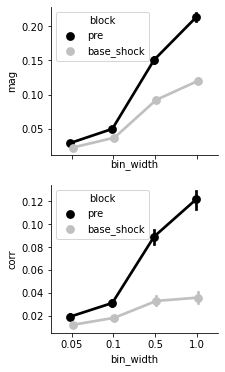

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from drn_interactions.plots import PAL_GREY_BLACK

sns.set_palette(PAL_GREY_BLACK)
res_corr["mag"] = res_corr["corr"].abs()
res_pcup["mag"] = res_pcup["cc"].abs()


f = plt.figure(figsize=(3, 6))
ax = f.subplots(2, 1, sharex=True)

sns.pointplot(data=res_corr, x="bin_width", y="corr", hue="block", dodge=True, ax=ax[1])
sns.pointplot(data=res_corr, x="bin_width", y="mag", hue="block", dodge=True, ax=ax[0])

sns.despine(fig=f)

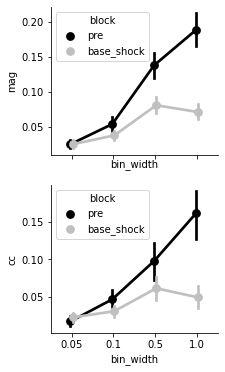

In [7]:
f = plt.figure(figsize=(3, 6))
ax = f.subplots(2, 1, sharex=True)

sns.pointplot(data=res_pcup, x="bin_width", y="cc", hue="block", dodge=True, ax=ax[1])
sns.pointplot(data=res_pcup, x="bin_width", y="mag", hue="block", dodge=True, ax=ax[0])

sns.despine(fig=f)